In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [85]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
    'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

Define some material parameters

Build temperature as function of location

In [19]:
def zeta_0_of_eps(epsilon):

    return np.arccosh(1/epsilon)

def coeff_F_m(m, epsilon):
    """ Returns mth coefficient 
        """
    zeta_0 = zeta_0_of_eps(epsilon)

    numer = -(2*2**(1/2)*np.sinh(zeta_0)*np.exp(-(m+(1/2))*zeta_0))
    denom = ((m+1)*np.sinh((m+(3/2))*zeta_0))    
    
    f_m = (
        numer
        /
        denom
        )

#     f_m[numer == 0] = 0
    
    return f_m


def coeff_G_m(m, epsilon):
    """ Returns mth coefficient 
        """
    zeta_0 = zeta_0_of_eps(epsilon)
    
    g_m = (m+1)**(-1)*( 
        1 + (
            (2*m*np.cosh(zeta_0)*np.sinh((m+(1/2))*zeta_0))
            /
            np.sinh((m+(3/2))*zeta_0)
            )
        )
    
    return g_m


def est_B_0(m_inf, epsilon):
    """ Estimates (returns) first coefficient B_0 from the limit 
            B_0 = -lim_{m->inf} H_m
        where 
            H_m = F_m + G_m H_{m-1} + (1 - G_m) H_{m-2}
            H_1 = F_1 + G_1 F_0 
            H_0 = F_0
        """
    zeta_0 = zeta_0_of_eps(epsilon)
    
    F_0 = coeff_F_m(0, epsilon)
    F_1 = coeff_F_m(1, epsilon)
    
    G_1 = coeff_G_m(1, epsilon)
    
    H_0 = F_0 
    if m_inf == 0:
        return -H_0
    H_1 = F_1 + G_1*F_0
    if m_inf == 1:
        return -H_1
    
    ## Iteratre through m vales from 2 to m_inf
    for m in range(2, m_inf+1):
        
        if m==2:
            H_m1 = H_1
            H_m2 = H_0
        
        G_m = coeff_G_m(m, epsilon)
        F_m = coeff_F_m(m, epsilon)
        
        H_m = F_m + G_m*H_m1 + (1 - G_m)*H_m2
        
        ## Define for next iteration
        H_m1 = H_m
        H_m2 = H_m1
    
    b_0 = -H_m 
    return b_0



Text(0.5, 0, '$m$')

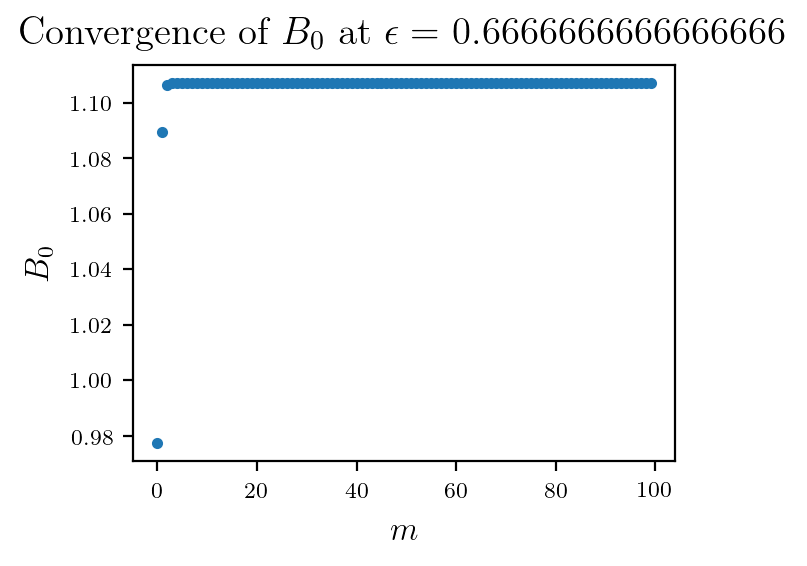

In [20]:
ms = np.arange(100)
eps = 2/3
b0s = [est_B_0(n, eps) for n in ms]

plt.plot(ms, b0s, lw=0, marker='.')
plt.title(f'Convergence of $B_0$ at $\epsilon = $ {eps}')
plt.ylabel(f'$B_0$')
plt.xlabel(f'$m$')


In [21]:
def series_B_m(m, B_0, epsilon):
    """ Returns array of length 'm' containing the first m coefficients 
        defined recurrisvly on the first coefficient 'B_0'
        """
    Bs = np.zeros(m+1)
    Bs[0] = B_0
    
    if m==0:
        return Bs
    
    F_0 = coeff_F_m(0, epsilon)
    B_1 = F_0 + B_0
    Bs[1] = B_1
    if m==1:
        return Bs
    
    ## Iteratre through m vales from 2 to m_inf
    for _m in range(2, m+1):
        
        B_m1 = Bs[_m-1]
        B_m2 = Bs[_m-2]

        G_m1 = coeff_G_m(_m-1, epsilon)
        F_m1 = coeff_F_m(_m-1, epsilon)
        
        Bs[_m] = F_m1 + G_m1*B_m1 + (1 - G_m1)*B_m2
    
    return Bs
        

In [22]:
series_B_m(4, 1.6, .6)

array([1.6       , 0.72971473, 0.65059789, 0.6415015 , 0.64045914])

In [23]:
# def coeff_D_m(m, epsilon):
    
#     zeta_0 = zeta_0_of_eps(epsilon)
    
#     D_m = (
#         (np.sinh(zeta_0)*np.cosh((m+0.5)*zeta_0))/2 
#         + 
#         (m+.5)*np.cosh(zeta_0)np.sinh((m+0.5)*zeta_0)
#         )
    
#     return D_m


# def coeff_E_m(m, epsilon):
    
#     zeta_0 = zeta_0_of_eps(epsilon)
    
#     E_m = (m+0.5)*np.sinh((m+0.5)*zeta_0)
    
#     return E_m


def temp_unitless_biph_coords(
    zeta, 
    beta,
    l,
    epsilon,
    max_m,
    B_0, 
    return_terms=False
    ):
    """ Unitless temperature around 2 spheres of radii 'l' and 
        center-center seperation  as a function of bispherical 
        coordinates '2l/epsilon'. The expression is defined as a series 
        of coefficients B_m which are defined by recursion relation over 
        
        Assuming zeta and betas correspond to coordinate pairs
        """
    zeta = np.asarray(zeta)
    beta = np.asarray(beta)
    
    ## Get array of B_m coefficients
    array_B_m = series_B_m(max_m, B_0, epsilon,)
    
    m_array = np.arange(0, max_m+1, 1)
#     array_D_m = coeff_D_m(m_array, epsilon)
#     array_E_m = coeff_E_m(m_array, epsilon)

    ## zetas and coordinate pairs, so only one coordinate dimension is
    ## neccesary.
    legendre_P = np.zeros((len(beta), len(m_array)))
    
    for m in m_array:
        legendre_P[:, m] = spl.legendre(m)(np.cos(beta))
    
    sum_on_m_terms = (
        array_B_m[None, :]
        *
        np.cosh((m_array[None, :]+0.5)*zeta[:, None])
        *
        legendre_P
        )
    
    prefactor = np.sqrt(
        np.cosh(zeta)
        -
        np.cos(beta)
        )
    
    if return_terms:
        return prefactor[:, None]*sum_on_m_terms
    
    sum_on_m = np.sum(sum_on_m_terms, axis=-1)
    
    theta = (
        prefactor
        * 
        sum_on_m
        )
        
    return theta
    

Define coordinate transformation

In [24]:
def biph_transform(x, y, z, epsilon):
    
    x = np.asarray(x)[:, None, None]
    y = np.asarray(y)[None, :, None]
    z = np.asarray(z)[None, None, :]

    c = np.sqrt(epsilon**(-.2)-1)
    R = np.sqrt(x**2. + y**2. + z**2.)
    Q = np.sqrt((R**2. + c**2.)**2. - (2*c*z)**2.)

    zeta = np.arcsinh(2*c*z/Q).ravel()
    beta = np.arccos((R**2. - c**2.)/Q).ravel()
    
    return (zeta, beta)

In [25]:
## Define an epsilon 
eps_test = 2/3

min_cartcoord, max_cartcoord = (-1, 1)
num_coords = 100
coord_domain = np.linspace(min_cartcoord, max_cartcoord, num_coords)

x_test = coord_domain
y_test = [0]
z_test = coord_domain

zeta_test, beta_test = biph_transform(
    x_test, y_test, z_test, eps_test)

Trying to understand this implementation, try plotting zeta and beta

In [26]:
# plt.imshow(
#     zeta_test.reshape((num_coords, num_coords)), 
#     origin='lower', 
#     extent=[min_cartcoord, max_cartcoord, min_cartcoord, max_cartcoord])

In [27]:
# plt.imshow(
#     beta_test.reshape((num_coords, num_coords)), 
#     origin='lower', 
#     extent=[min_cartcoord, max_cartcoord, min_cartcoord, max_cartcoord])

In [90]:
temp = temp_unitless_biph_coords(
    zeta = zeta_test, 
    beta = beta_test,
    l=1,
    epsilon=eps_test,
    max_m=3,
    B_0=b0s[-1],
    )

temp.shape

(10000,)

In [91]:
# plt.imshow(
#     temp.reshape((num_coords, num_coords)), 
#     origin='lower', 
#     extent=[min_cartcoord, max_cartcoord, min_cartcoord, max_cartcoord])
# plt.colorbar()

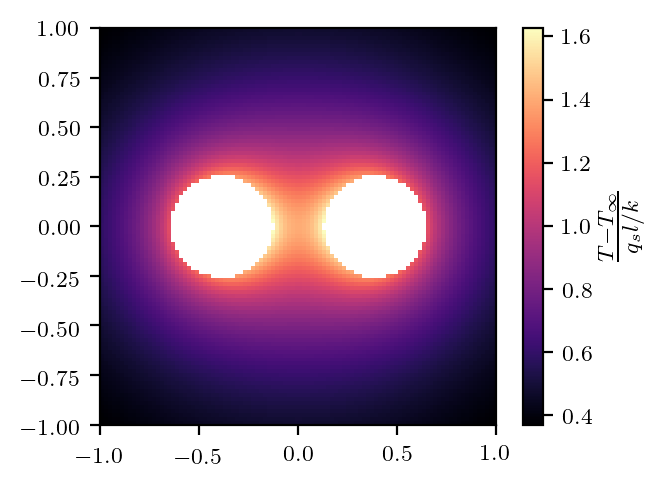

In [92]:
ma_temp = np.ma.masked_where(
    np.abs(zeta_test.reshape((num_coords, num_coords))) > zeta_0_of_eps(eps_test),
    temp.reshape((num_coords, num_coords))
    )

plt.imshow(
    ma_temp, 
    origin='lower', 
    extent=[min_cartcoord, max_cartcoord, min_cartcoord, max_cartcoord])
plt.colorbar(label=r'$\frac{T-T_\infty}{q_s l/k}$')
# plt.xlabel()

### Trying to undestand why adding higher order terms in m breaks the plot. 

I will plot the difference between consebutive terms

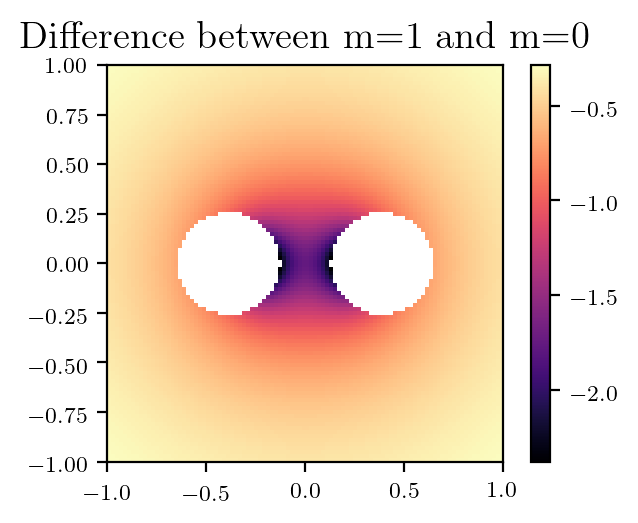

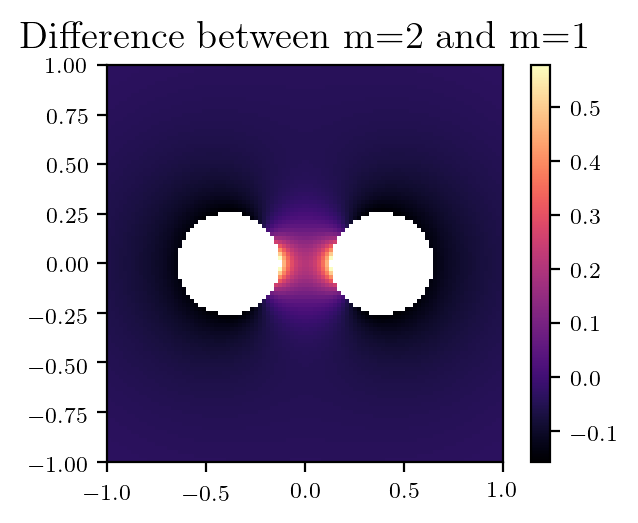

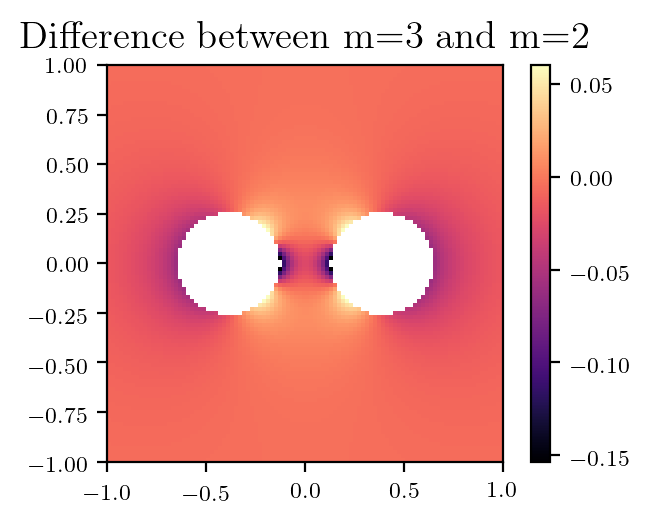

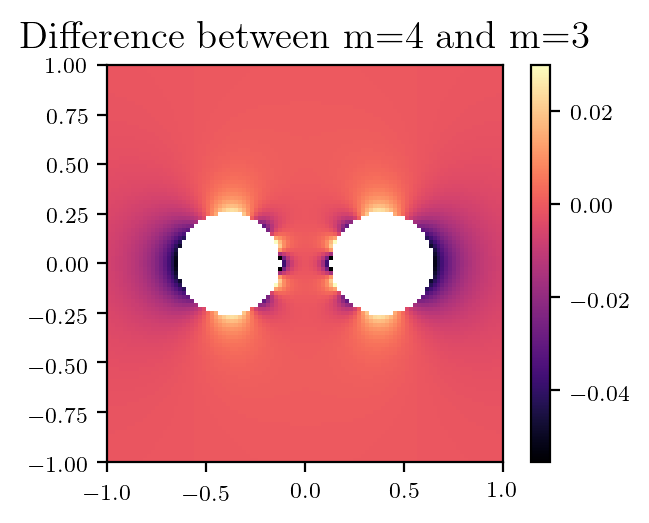

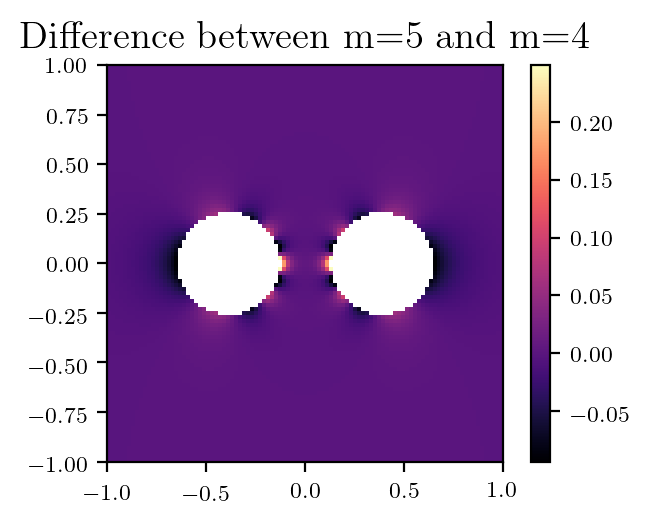

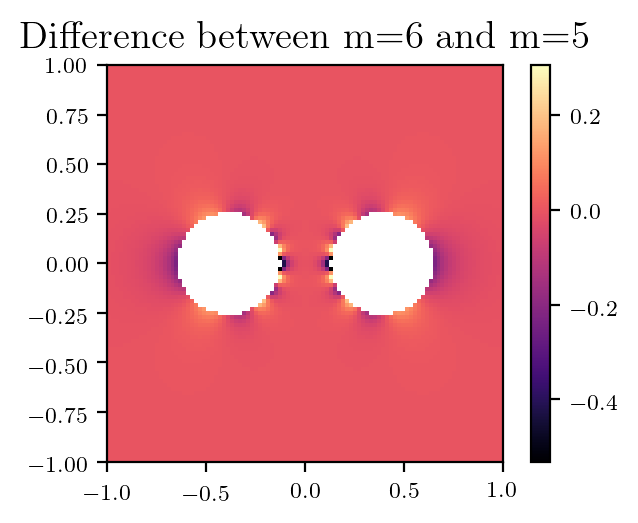

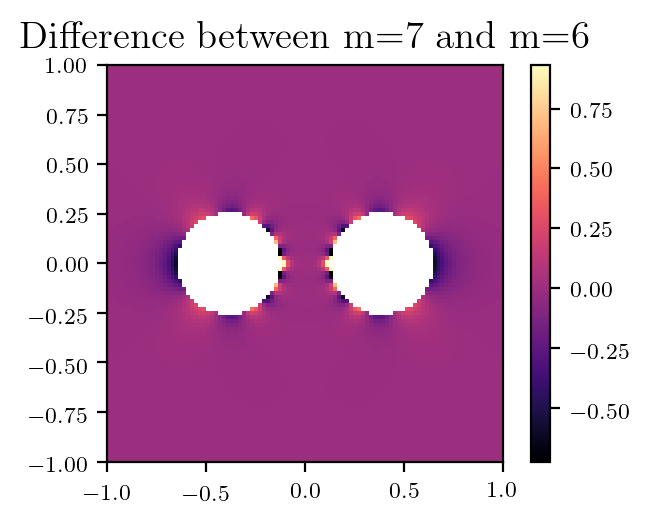

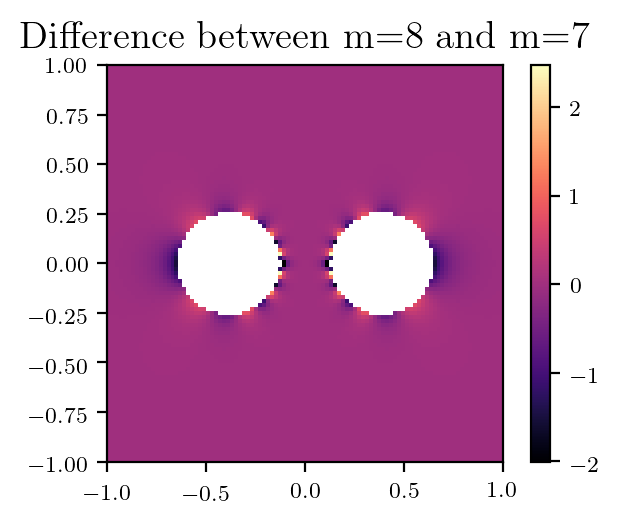

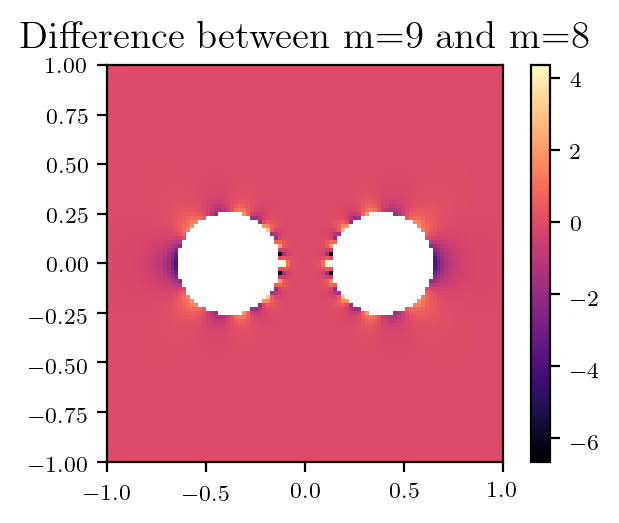

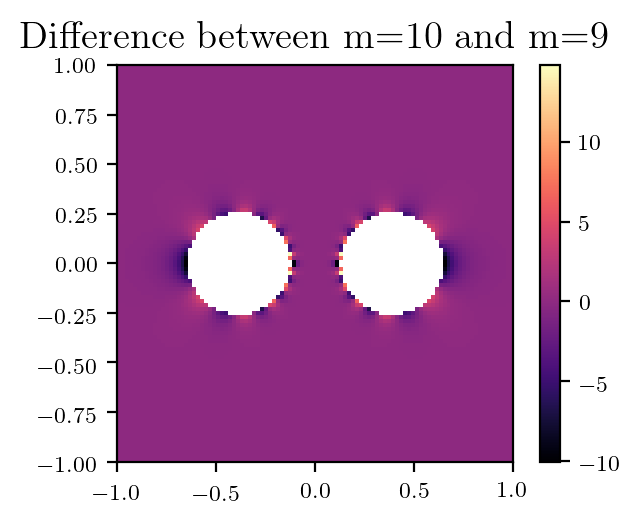

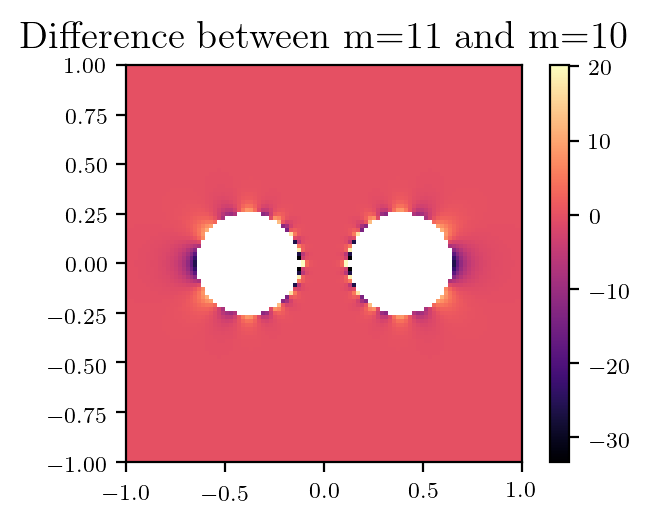

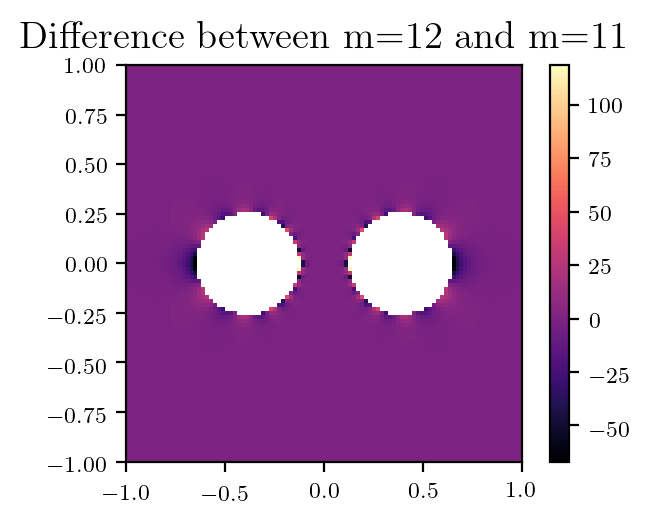

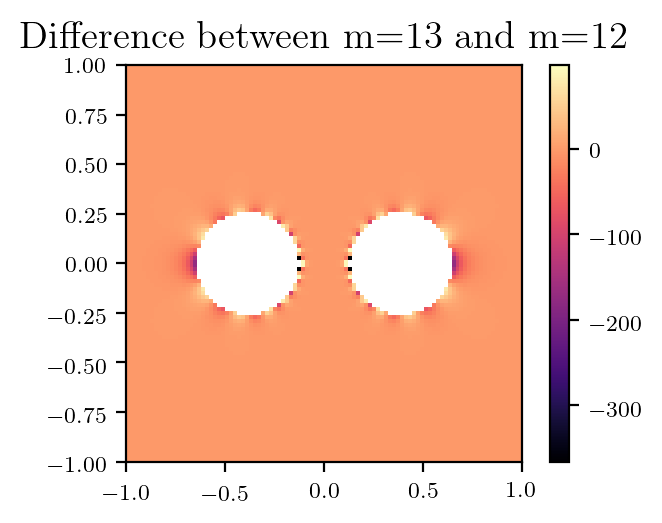

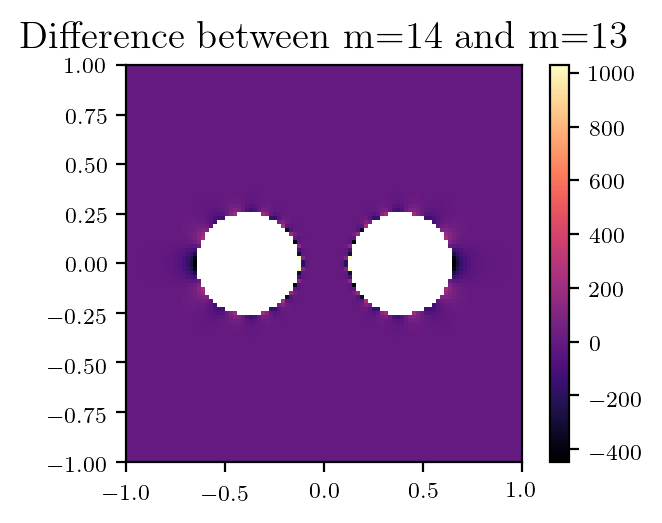

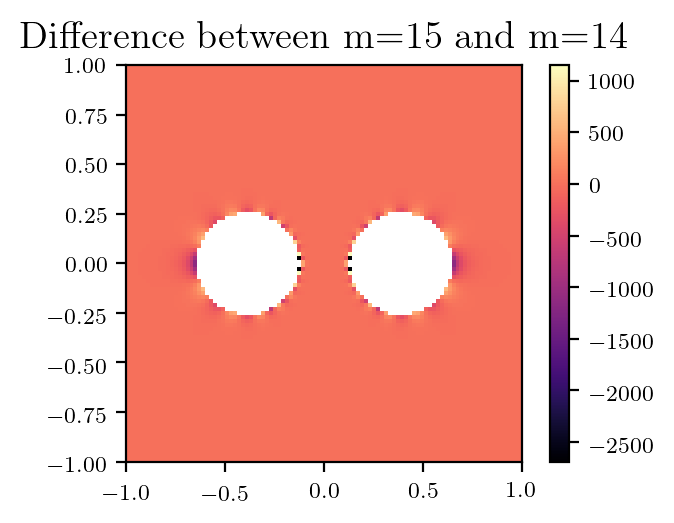

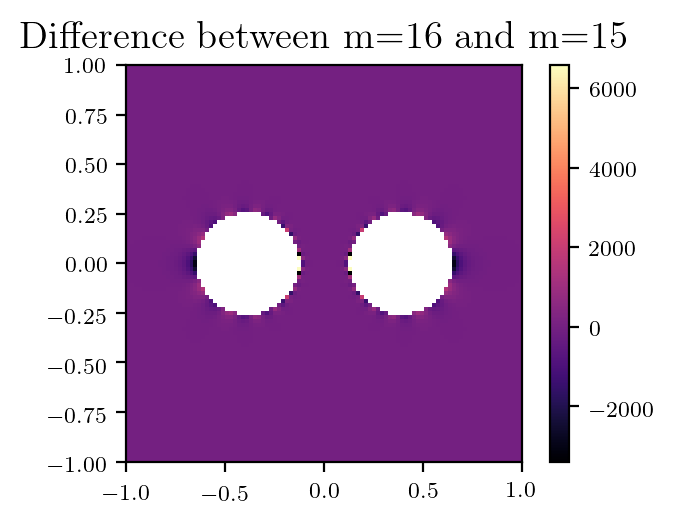

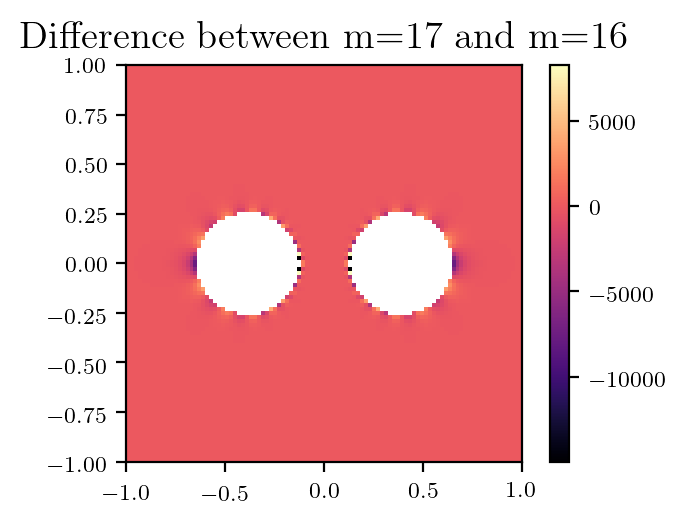

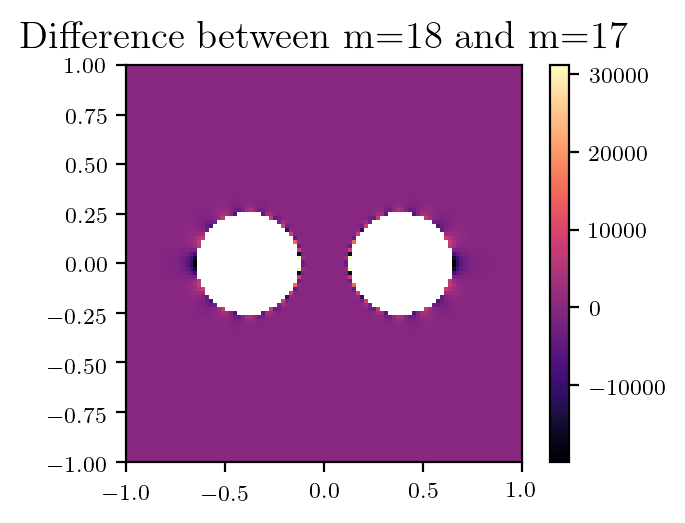

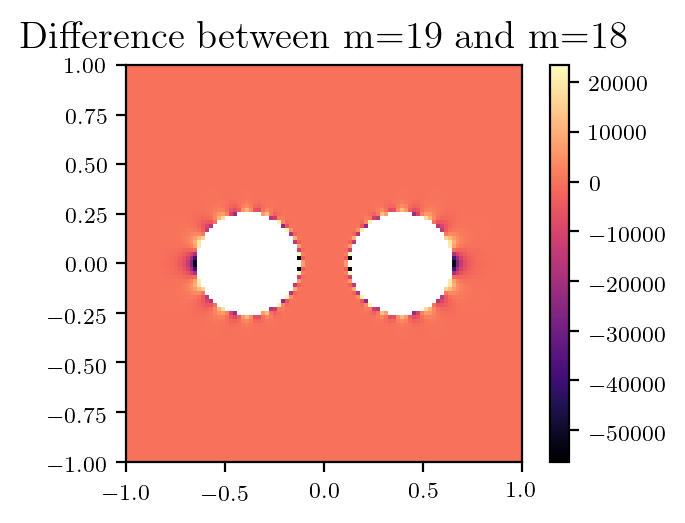

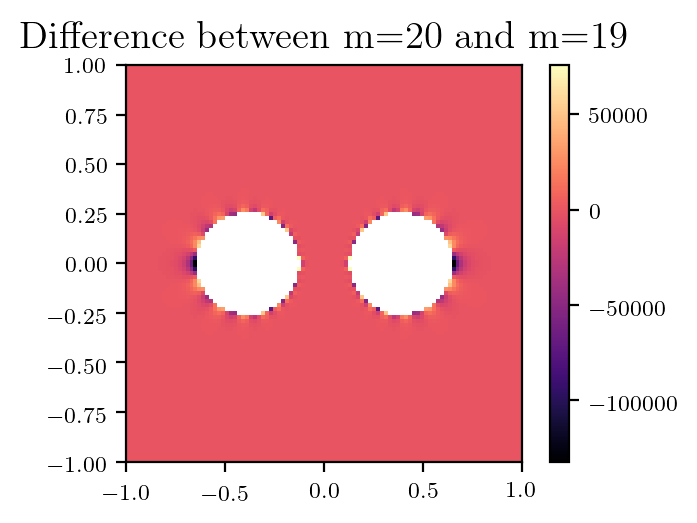

In [33]:
temp = temp_unitless_biph_coords(
    zeta = zeta_test, 
    beta = beta_test,
    l=1,
    epsilon=eps_test,
    max_m=20,
    B_0=b0s[-1],
    return_terms=1
    )
temp.shape

for i, diff in enumerate(np.diff(temp, axis=-1).T):

    _diff = np.ma.masked_where(
        np.abs(zeta_test.reshape(
            (num_coords, num_coords))) > zeta_0_of_eps(eps_test),
        diff.reshape((num_coords, num_coords))
        )

    plt.figure()
    plt.imshow(
        _diff, 
        origin='lower', 
        extent=[
            min_cartcoord, 
            max_cartcoord, 
            min_cartcoord, 
            max_cartcoord])
    plt.colorbar()
    plt.title(f'Difference between m={i+1:d} and m={i:d}')
    

# Try touching spheres to figure out coords

In [ ]:
## Define an epsilon 
eps_test = 1

In [ ]:
ms = np.arange(100)

b0s = [est_B_0(n, eps_test) for n in ms]

plt.plot(ms, b0s, lw=0, marker='.')
plt.title(f'Convergence of $B_0$ at $\epsilon = $ {eps_test}')
plt.ylabel(f'$B_0$')
plt.xlabel(f'$m$')


In [ ]:


min_cartcoord, max_cartcoord = (-1, 1)
num_coords = 100
coord_domain = np.linspace(min_cartcoord, max_cartcoord, num_coords)

x_test = coord_domain
y_test = [0]
z_test = coord_domain

zeta_test, beta_test = biph_transform(
    x_test, y_test, z_test, eps_test)

In [ ]:
temp = temp_unitless_biph_coords(
    zeta = zeta_test, 
    beta = beta_test,
    l=1,
    epsilon=eps_test,
    max_m=3,
    B_0=b0s[-1],
    )

temp.shape

In [ ]:
temp

In [ ]:
# plt.imshow(
#     temp.reshape((num_coords, num_coords)), 
#     origin='lower', 
#     extent=[min_cartcoord, max_cartcoord, min_cartcoord, max_cartcoord])
# plt.colorbar()

In [ ]:
ma_temp = np.ma.masked_where(
    np.abs(zeta_test.reshape((num_coords, num_coords))) > zeta_0(eps_test),
    temp.reshape((num_coords, num_coords))
    )

plt.imshow(
    ma_temp, 
    origin='lower', 
    extent=[min_cartcoord, max_cartcoord, min_cartcoord, max_cartcoord])
plt.colorbar(label=r'$\frac{T-T_\infty}{q_s l/k}$')
# plt.xlabel()

Why is this breaking? Seems like the F and G coefficients are going to 0/0

In [ ]:
np.arccosh(1)

In [ ]:
np.sinh(0.0000001)

In [ ]:
coeff_F_m(1, 1)

In [ ]:
_numer = lambda m, zeta_0: -(2*2**(1/2)*np.sinh(zeta_0)*np.exp(-(m+(1/2))*zeta_0))
_denom = lambda m, zeta_0: ((m+1)*np.sinh((m+(3/2))*zeta_0))

In [ ]:
_denom(1, np.sinh(0.0001))

In [ ]:
_numer(1, np.sinh(0.0001))

In [ ]:
## Check how numerator and denominator of fm approach 0

approaching_zero = np.logspace(-1, -5, 100)

plot_m_terms = 6
for m in range(plot_m_terms): 
    plt.plot(approaching_zero, _numer(m, approaching_zero), label='numer')
    plt.plot(approaching_zero, _denom(m, approaching_zero),ls='--', label='denom')

plt.xscale('log')
# plt.legend()

Still have not figured this out, but I am going to move on to calculating temperatures. 

In [38]:
def two_sph_unitless_temp(
    epsilon,
    max_m,
    B_0,
    return_terms=False
    ):
    """ Returns analytic result for the average surface temperature in
        terms of another seires of the Bm coefficients 
        """
    zeta_0 = zeta_0_of_eps(epsilon)
    
    ## Get array of B_m coefficients
    array_B_m = series_B_m(max_m, B_0, epsilon,)
    
    m_array = np.arange(0, max_m+1, 1)
    
    sum_on_m_terms = (
        array_B_m
        *
        (1 + np.exp(-(2*m_array+1)*zeta_0))
        )
    
    prefactor = (
        np.sinh(zeta_0)
        /
        np.sqrt(2)
        )
    
    if return_terms:
        return prefactor[:, None]*sum_on_m_terms
    
    sum_on_m = np.sum(sum_on_m_terms, axis=-1)
    
    theta_bar = (
        prefactor
        * 
        sum_on_m
        )
    return theta_bar


In [39]:
two_sph_unitless_temp(
    epsilon=eps_test,
    max_m=3,
    B_0=b0s[-1])

1.3328526568252175

In [47]:
def eps_of_ccsep(num_radii):
    """ returns epsilon given number of radii connecting sphere centers
        """
    eps = 2/num_radii
    return eps

In [49]:
epss = eps_of_ccsep(np.linspace(3, 10, 10))

temps = np.zeros_like(epss)

for i, e in enumerate(epss):
    temps[i] = two_sph_unitless_temp(
        e, 
        3, 
        b0s[-1])
    

Make sure I am estimating B_0 correctly for each epsilon

In [60]:
def converged_B_0(epsilon, m_inf, tol=.01):
    """ Iterate m->inf until B0 changes by less then 'tol' of last 
        value """

    B0 = est_B_0(0, epsilon)

    for m in range(1, m_inf+1):
        
        new_B0 = est_B_0(m, epsilon)
        diff = new_B0 - B0

        if diff/new_B0 < tol:
            return new_B0
        
        else: B0 = new_B0
            
    raise ValueError("B_0 did not converge")
            

In [65]:
converged_B_0(2/3, 4)

1.1070767805908388

Text(0, 0.5, '$\\overline{\\theta}$')

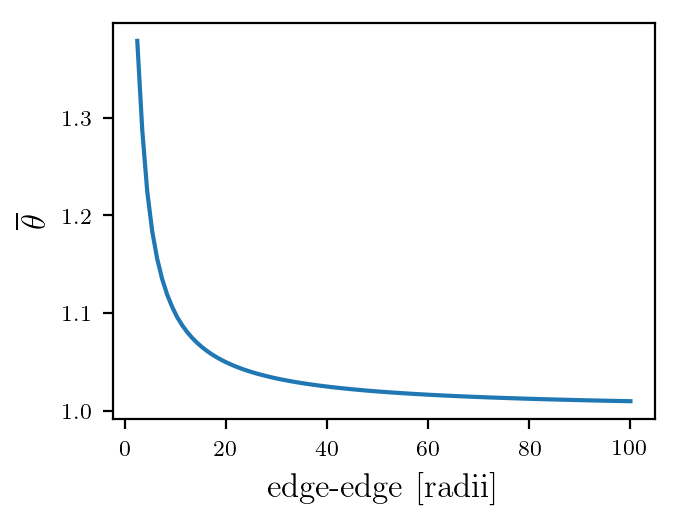

In [82]:
## Try this again 
radii = np.linspace(2.5, 100, 100)
epss = eps_of_ccsep(radii )

temps = np.zeros_like(epss)

for i, e in enumerate(epss):
    temps[i] = two_sph_unitless_temp(
        e, 
        3, 
        converged_B_0(e, 10))
    
plt.plot(radii, temps)
plt.xlabel(r'edge-edge [radii]')

plt.ylabel(r'$\overline{\theta}$')

# Model absorption to get heat flux

In [115]:
eps1 = -2.5676 + 1j*3.6391
n0 = 1.473
eps0 = n0**2

Eplane = (1.4444)**0.5 * 10**18 * 10**(-1)

def elec(dip_angle, x, y, k):
    """ Dipole field of an x oriented dipole"""
    
    E = aff.E_field(
        dipole_orientation_angle=dip_angle, 
        xi=x, 
        y=y, 
        k=k
        )
    
    return E/k**3


def g(
    d_angle,
    d, w, 
    scale=1, 
    n_b=n0,
    p1_angle=0, p2_angle=0,):
    
    ## rotate d vector
    R = cp.rotation_by(d_angle)
    d_col = (R @ np.array([[d, 0, 0]]).T).T
    
    ## Get coupling strength from misloc package
    G = cp.G(
        drive_hbar_w=hbar*w, 
        d_col=d_col, 
        n_b=n_b)
    ## but this was implemented to process multiple seperations d or 
    ## frequencies w, so returns shape (1, 3, 3)
    if G.shape[0] is 1:
        G = G[0]
    
    def p_hat(angle):
        return cp.rotation_by(angle) @ np.array([1,0,0])[:,None]
    
    g = p_hat(p1_angle).T @ G @ p_hat(p2_angle)
    
    return g[...,0,:]


def p_coupled(
    w, d,
    alpha, other_alpha,
    probe_E=Eplane):

    p = (
        (alpha*(1 + g(0, d, w,)*other_alpha)*probe_E)
        /
        (1 - alpha*other_alpha*g(0, d, w,)**2)
        ) 
    
    if len(p.ravel()) is 1:
        p = p.ravel()
    
    return p

def pow_abs_coupled(
    w, d,
    alpha, that_alpha,
    x_dip=None,
    x_that_dip=None,
    x_obs=None,    
    probe_E=Eplane,
    n_b=n0,
    imaging_mode=None
    ): 
    """ Defines the power absorbed by one of two coupled dipoles.
    
        Assumes scalar polarizabilities
        """
    x_obs = np.asarray(x_obs)
    
    if x_dip is None and x_that_dip is None:
        x_dip = -d/2
        x_that_dip = d/2
    
    if imaging_mode is None:
        raise ValueError("'imaging_mode' must be 'wf' or 'cf'")
        
    k = w*n_b/c    
    _g = g(0, d, w,)
    
    ## Set up incident field depensing on imaging modality
    if imaging_mode is 'cf':
        if x_obs is None:
            raise ValueError("Need 'x_obs' if 'imaging_mode'='cf'")
        ## Define spactially dependent driving field
        this_probe_E = elec(
            0, 
            x=x_dip-x_obs,
            y=0, 
            k=k
            )[0] * probe_E
        that_probe_E = elec(
            0, 
            x=x_that_dip-x_obs,
            y=0, 
            k=k
            )[0] * probe_E
    elif imaging_mode is 'wf':
        this_probe_E = probe_E
        that_probe_E = probe_E
        
    ## Work done on dipole by incident field and coupling
    E_tot_time_geom_coupling = (
        (this_probe_E + _g*that_alpha*that_probe_E)
        /
        (1 - alpha*that_alpha*_g**2)
        )
    
    p = alpha*E_tot_time_geom_coupling 
    
    alpha_inv_star_dot_p_star = np.conj(E_tot_time_geom_coupling) 
    
    term_1 = np.imag(p * alpha_inv_star_dot_p_star)
    
    ## Define work done on dipole by its own field (Larmore power)
    term_2 = (2/3) * k**3. * np.abs(p)**2. 
    
    _pow_abs = w/2 * (term_1 - term_2)
    
    return _pow_abs

In [107]:
## Test 
pow_abs_coupled(
    x_obs=[1, 2, 3],
    x_dip=0,
    x_that_dip=0,
    w=1, 
    d=1,
    alpha=1, 
    that_alpha=1,
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

array([-253.82233713, -253.82233713, -253.82233713])

Thinking I can just use this simpler implemention of the coupled dipoles with the sphere polarizability from `mmp.calc.cp`
```
cp.sparse_ret_sphere_polarizability_Drude(w, eps_inf, w_p, gamma,
    eps_b, a, isolate_mode=None)
```

But the naive function I wrote takes a scalar polarizability

In [125]:
a1 = 40
a2 = 40

del_d = 134

d = a1 + del_d + a2

hw = 2.2
sensorsize_nm = 1000

In [126]:
alpha_1 = cp.sparse_ret_sphere_polarizability_Drude(
    w=hw/hbar, 
    eps_inf=14.2, 
    w_p=10.0/hbar, 
    gamma=0.20/hbar,
    eps_b=1.33**2., 
    a=a1*1e-7, 
    )

alpha_2 = cp.sparse_ret_sphere_polarizability_Drude(
    w=hw/hbar, 
    eps_inf=14.2, 
    w_p=10.0/hbar, 
    gamma=0.20/hbar,
    eps_b=1.33**2., 
    a=a2*1e-7, 
    )

Text(0.5, 1.0, 'Power abs. by two 40 nm spheres')

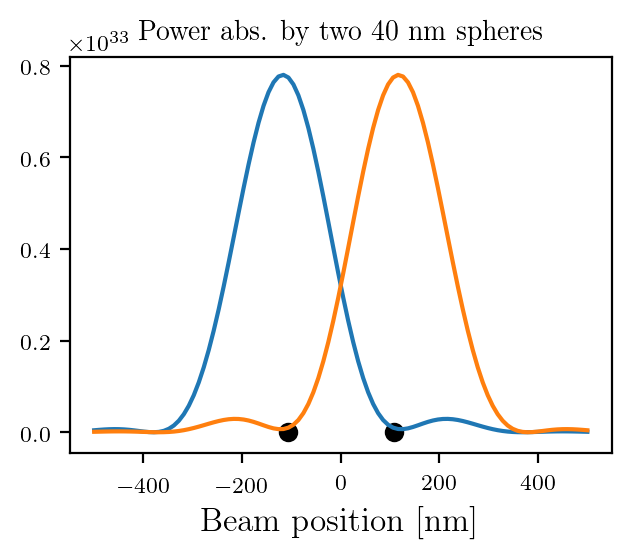

In [134]:
obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

pow_test_1 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=hw/hbar, 
    d=d*1e-7,
    alpha=alpha_1[0,0], 
    that_alpha=alpha_2[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

pow_test_2 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=+d*1e-7/2,
    x_that_dip=-d*1e-7/2,
    w=hw/hbar, 
    d=d*1e-7,
    alpha=alpha_2[0,0], 
    that_alpha=alpha_1[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

plt.plot(obs_points*1e7, pow_test_1)
plt.plot(obs_points*1e7, pow_test_2)
plt.xlabel('Beam position [nm]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c='k')
plt.title('Power abs. by two 40 nm spheres', fontsize=10)


Realizing that I can't use the results from the paper for confocal imaging because the heat flux out of the two spheres is not the same. Might be time to do some math, unless I want to integrate with Widefield... I guess it might be worth it. But I am less interested in that.

In [ ]:
## Calculate temperature
## Try this again 
radii = d/40*1e-7
epss = eps_of_ccsep(radii)

temps = np.ones_like(obs_points) * two_sph_unitless_temp(
        epsilon=e, 
        max_m=3, 
        B_0=converged_B_0(e, 10))

for i, e in enumerate(obs_points):
    temps[i] = two_sph_unitless_temp(
        epsilon=e, 
        max_m=3, 
        B_0=converged_B_0(e, 10))
    
plt.plot(radii, temps)
plt.xlabel(r'edge-edge [radii]')

plt.ylabel(r'$\overline{\theta}$')